In [7]:
#Import libraries and define settings for plotting
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
sns.set()
pal = sns.hls_palette(10, h=.5)
sns.set_palette(pal)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [8]:
df_uber = pd.read_csv('uber_nyc_data.csv')

In [9]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 6 columns):
id                 int64
origin_taz         object
destination_taz    object
pickup_datetime    object
trip_distance      float64
trip_duration      object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.4+ GB


In [10]:
df_uber.head(6)

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
0,252581,7C,6A,2014-09-01 09:00:00,4.2500,0:15:11
1,252582,7B,15,2014-09-01 18:00:00,10.1700,0:34:05
2,252583,11,2A,2014-09-01 17:00:00,4.0200,0:17:06
3,252584,3B,4A,2014-09-01 13:00:00,1.4600,0:06:32
4,252585,2A,10,2014-09-01 14:00:00,8.3100,0:26:17
5,252586,5B,4C,2014-09-01 12:00:00,1.0400,0:08:35


## Check for missing or erroneous data.

In [11]:
len(df_uber[df_uber.duplicated() == True])

0

In [12]:
df_uber.isnull().sum()

id                       0
origin_taz               0
destination_taz    1273023
pickup_datetime          0
trip_distance           38
trip_duration           38
dtype: int64

In [13]:
arr1 = df_uber.origin_taz.unique()
arr1

array(['7C', '7B', '11', '3B', '2A', '5B', '10', '2B', '9', '6B', '15',
       '4C', '5A', '8', '14', '4A', '7A', '1', '16', '3A', '2C', '6A',
       '12', '13', '3C', '4B', '5C', '17'], dtype=object)

In [14]:
arr2 = df_uber.destination_taz.unique() 
arr2

array(['6A', '15', '2A', '4A', '10', '4C', '7A', '3C', '5B', '14', '8',
       nan, '7C', '12', '2C', '1', '6B', '5C', '9', '3A', '2B', '11',
       '7B', '5A', '13', '4B', '18', '16', '3B', '17'], dtype=object)

In [15]:
set(arr2)-set(arr1)

{'18', nan}

In [16]:
df_uber[df_uber.destination_taz.isnull()].head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15,252596,6B,NaN,2014-09-01 17:00:00,11.6700,0:23:45
32,252613,9,NaN,2014-09-01 16:00:00,80.6900,1:59:37
63,252644,9,NaN,2014-09-01 18:00:00,23.0700,1:03:37
141,252722,9,NaN,2014-09-01 10:00:00,21.7300,0:41:12
148,252729,4B,NaN,2014-09-01 10:00:00,4.6200,0:14:55


In [17]:
#There are 38 records with values missing for trip distance and duration, none of which are missing the de
df38 = df_uber[df_uber.trip_duration.isnull() & df_uber.trip_distance.isnull()]
df38.head()

,id,origin_taz,destination_taz,pickup_datetime,trip_distance,trip_duration
15155317,39535,2A,11,2015-04-25 12:00:00,nan,NaN
15245057,1009076,2A,2A,2015-04-26 01:00:00,nan,NaN
16519652,15028665,2A,7C,2015-04-29 21:00:00,nan,NaN
17148253,22250173,2A,2A,2015-04-12 02:00:00,nan,NaN
17297563,23716998,2C,11,2015-04-25 13:00:00,nan,NaN


In [18]:
#All cases for which trip_duration is null match the cases for which trip_distance is also null:
len(df_uber[(df_uber.trip_duration.isnull() == False) & (df_uber.trip_distance.isnull())])

0

## Parse the pickup_datetime column to datetime type and create related features.

In [19]:
#None of the pickup time data offer minutes or seconds precision
len(df_uber[df_uber.pickup_datetime.apply(lambda x: x[-5:] == '00:00') == False])

0

In [20]:
df_uber.pickup_datetime[1]

'2014-09-01 18:00:00'

In [21]:
def dateParser(s):
    """
    Function that takes a string in the format yyyy-mm-dd hh:mm:ss, and
    returns the same as a datetime object.
    """
    return datetime.datetime(int(s[0:4]), int(s[5:7]), int(s[8:10]), int(s[11:13]))

In [22]:
#Apply parser to data
t0 = time.time()
df_uber['pu_date_hour'] = df_uber.pickup_datetime.apply(dateParser)
time.time() - t0

62.049455642700195

In [23]:
df_uber['pu_date_hour'].tail()

30925733   2015-09-01
30925734   2015-09-01
30925735   2015-09-01
30925736   2015-09-01
30925737   2015-09-01
Name: pu_date_hour, dtype: datetime64[ns]

In [24]:
#Data is from exactly 365 days from Sept 1st, 2014 to Sep 1st, 2015.
beginning = df_uber.pu_date_hour.min()
end = df_uber.pu_date_hour.max()
print (beginning, end, end - beginning )

2014-09-01 00:00:00 2015-09-01 00:00:00 365 days 00:00:00


In [25]:
#Drop repeated column
df_uber = df_uber.drop('pickup_datetime', axis=1)

### Create other date and time features.

In [26]:
#Create a column with the date, without the time. This will be useful later.
t0 = time.time()
df_uber['pu_date'] = pd.Series(map(lambda x: x.astype('datetime64[D]'), df_uber['pu_date_hour'].values))
time.time() - t0

74.50548529624939

In [27]:
#Get month and year from pick up timestamp
df_uber['year'] = df_uber['pu_date_hour'].dt.year
df_uber['month'] = df_uber['pu_date_hour'].dt.month

In [28]:
#Get trip pick up day of the month
t0 = time.time()
df_uber['day'] = df_uber['pu_date_hour'].dt.day #.apply(lambda x: x.day) = 105 seconds vs < 2 seconds with dt
time.time() - t0

3.3730456829071045

In [29]:
#Get trip pick up hour from timestamp
t0 = time.time()
df_uber['hour'] = df_uber['pu_date_hour'].dt.hour #< 2 seconds vs 101 seconds using apply lambda
time.time() - t0

2.3772127628326416

In [30]:
#Get trip pick up weekday from timestamp
t0 = time.time()
df_uber['weekday'] = df_uber['pu_date_hour'].dt.dayofweek
time.time() - t0

3.38655948638916

In [31]:
df_uber.weekday.value_counts() #Monday = 0, Sunday = 6

5    5142832
4    4805002
3    4625511
6    4331195
2    4301537
1    4010434
0    3709227
Name: weekday, dtype: int64

In [32]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0


In [33]:
df_uber.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30925738 entries, 0 to 30925737
Data columns (total 12 columns):
id                 int64
origin_taz         object
destination_taz    object
trip_distance      float64
trip_duration      object
pu_date_hour       datetime64[ns]
pu_date            datetime64[ns]
year               int64
month              int64
day                int64
hour               int64
weekday            int64
dtypes: datetime64[ns](2), float64(1), int64(6), object(3)
memory usage: 2.8+ GB


## Transform trip duration data.

In [40]:
#around 19393 entries
uniq_dur = df_uber[df_uber.trip_duration.isnull() == False].trip_duration.unique() 

In [35]:
#Among unique duration strings, find how many represent more than 10h of duration:
long_duration = []
for item in uniq_dur:
    if len(item) != 7:
        long_duration.append(item)

#long_duration
print (len(long_duration))

386


In [36]:
#Check for the most unusual strings for trip duration
for item in long_duration:
    if len(item) > 8:
        print(item)

172032:14:50
172032:39:03
136:25:12
172032:17:45
172032:19:27
119:53:35
120:49:05


In [37]:
#this fills the 38 tuples with null (missing) values with 0 value
def duration_to_minutes(s):
    if pd.isnull(s):
        val = 0 
    else:
        hms = s.split(':')
        val = int(hms[0])*60 + int(hms[1]) + int(hms[2])/60.0
    return val

In [38]:
#Transform the trip duration string into trip duration in minutes:
t0 = time.time()
df_uber['duration_min'] = df_uber.trip_duration.apply(duration_to_minutes) 
time.time() - t0

72.80228042602539

In [39]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min
0,252581,7C,6A,4.2500,0:15:11,2014-09-01 09:00:00,2014-09-01,2014,9,1,9,0,15.1833
1,252582,7B,15,10.1700,0:34:05,2014-09-01 18:00:00,2014-09-01,2014,9,1,18,0,34.0833
2,252583,11,2A,4.0200,0:17:06,2014-09-01 17:00:00,2014-09-01,2014,9,1,17,0,17.1000
3,252584,3B,4A,1.4600,0:06:32,2014-09-01 13:00:00,2014-09-01,2014,9,1,13,0,6.5333
4,252585,2A,10,8.3100,0:26:17,2014-09-01 14:00:00,2014-09-01,2014,9,1,14,0,26.2833


In [ ]:
df_uber.info()

## Replace missing values with mean distance and duration for respective origin-destination.

In [41]:
#Get the mean distance and duration for each origin-destination pair
df_DistDur = df_uber.groupby(['origin_taz', 'destination_taz'])[['trip_distance', 'duration_min']].mean()

In [42]:
df_DistDur.head()

trip_distance  duration_min
origin_taz destination_taz                             
1          1                       1.4219       10.5655
           10                      3.6508       17.9776
           11                      5.0937       22.4899
           12                      8.8878       29.1024
           13                     11.5831       32.1568

In [44]:
#Replace 38 missing values with the average distance and duration for the respective origin-destination pair
for i in df38.index:
    orig = df_uber.loc[i, 'origin_taz']
    dest = df_uber.loc[i, 'destination_taz']
    df_uber.loc[i, 'trip_distance'] = df_DistDur.loc[orig, dest].trip_distance
    df_uber.loc[i, 'duration_min'] = df_DistDur.loc[orig, dest].duration_min

## Calculate average speed for each trip.

In [45]:
#Calculate average trip speed (mph) to help in understanding outliers (like trips with duration >10 h):
df_uber['trip_mph_avg'] = df_uber.trip_distance/(df_uber.duration_min/60.0)

In [46]:
#Check that trip_distance and duration_min have been replaced, and trip speed has been calculated:
df_uber.iloc[df38.index, :].head()

,id,origin_taz,destination_taz,trip_distance,trip_duration,pu_date_hour,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg
15155317,39535,2A,11,3.9368,NaN,2015-04-25 12:00:00,2015-04-25,2015,4,25,12,5,19.7321,11.9708
15245057,1009076,2A,2A,1.3588,NaN,2015-04-26 01:00:00,2015-04-26,2015,4,26,1,6,10.9195,7.4660
16519652,15028665,2A,7C,9.0394,NaN,2015-04-29 21:00:00,2015-04-29,2015,4,29,21,2,30.2041,17.9566
17148253,22250173,2A,2A,1.3588,NaN,2015-04-12 02:00:00,2015-04-12,2015,4,12,2,6,10.9195,7.4660
17297563,23716998,2C,11,4.8331,NaN,2015-04-25 13:00:00,2015-04-25,2015,4,25,13,5,24.3851,11.8918


In [47]:
#Drop redundant trip_duration columns
df_uber = df_uber.drop('trip_duration', axis=1)
df_uber = df_uber.drop('pu_date_hour', axis=1)

## Calculate Estimated Revenue per Trip.

In [48]:
#Source: http://uberestimate.com/prices/New-York-City/ for Uber X
base_fare = 2.55
per_minute = 0.35
per_mile = 1.75
min_fare = 8

In [49]:
df_uber['est_revenue'] = df_uber.eval('@base_fare + duration_min * @per_minute + trip_distance * @per_mile')
df_uber.loc[df_uber.est_revenue < 8, 'est_revenue'] = min_fare

In [50]:
df_uber.head()

,id,origin_taz,destination_taz,trip_distance,pu_date,year,month,day,hour,weekday,duration_min,trip_mph_avg,est_revenue
0,252581,7C,6A,4.2500,2014-09-01,2014,9,1,9,0,15.1833,16.7947,15.3017
1,252582,7B,15,10.1700,2014-09-01,2014,9,1,18,0,34.0833,17.9032,32.2767
2,252583,11,2A,4.0200,2014-09-01,2014,9,1,17,0,17.1000,14.1053,15.5700
3,252584,3B,4A,1.4600,2014-09-01,2014,9,1,13,0,6.5333,13.4082,8.0000
4,252585,2A,10,8.3100,2014-09-01,2014,9,1,14,0,26.2833,18.9702,26.2917


## Filter Dataset, Define Functions, and Load Methods to be Used to Create Visualizations.

In [51]:
# #Create dataframe to be used for visualization with exactly 365 days of data, and max trip duration of 16h:
df_viz = df_uber[(df_uber.pu_date != datetime.date(2015, 9, 1)) & (df_uber.duration_min <= 960)].copy() #1975 cases

D:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  


In [57]:
#Required by Plotly:
import matplotlib.mlab as mlab
# import chart-studio.plotly as py

In [58]:
# from matplotlib.ticker import FuncFormatter #Call formatter function to format tick values
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox) #Create image box
from matplotlib._png import read_png #Load png file
from matplotlib.patches import Ellipse #Draw ellipse

In [59]:
#Define robust function to automatically add annotated labels on bar plots.

def annotate_labels(ax, labels_list, **kwargs):
    """
    Function to automatically add labels on bar charts.
    It takes a plot axis, an ordered list of labels, and text kwargs.
    """
    
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom
    
    rects = ax.patches

    for rect, label in zip(rects, labels_list):
        height = rect.get_height()
        p_height = (height / y_height) # Fraction of axis height taken up by this rectangle
        label_position = height + (y_height * 0.01)
        
        # If we can fit the label above the column, do that;
        # otherwise, put it inside the column (or else, change ylim)
        #if p_height > 0.95:
        #    label_position = height - (y_height * 0.05)
        #else:
        #    label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position, label, kwargs)
    return None

## Visualizing the demand: number of Uber trips per day.

In [60]:
#Create a plotting dataframe with counts (number of trips) grouped by day:
byDate = df_viz.groupby('pu_date')['id'].count() #365 complete entries
byDate.head()

pu_date
2014-09-01    31592
2014-09-02    41496
2014-09-03    46339
2014-09-04    53402
2014-09-05    59718
Name: id, dtype: int64

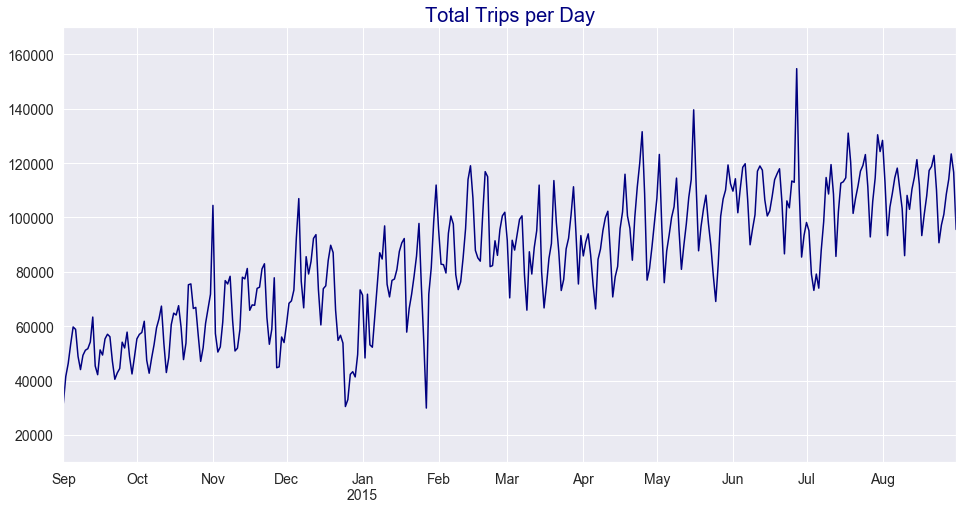

In [63]:
#Create a plot with the total number of trips per day, highlighting some changepoints associated with major holidays 
#and other weather and touristic/cultural events.

fig = plt.figure()

ax = byDate.plot(figsize = (16, 8), fontsize = 12, ylim = (10000, 170000), color = 'navy')

plt.title('Total Trips per Day', fontsize= 20, color='navy')
plt.tick_params(labelsize=14)
plt.xlabel('')

plt.show()
# plot_url = py.plot_mpl(fig)

## The effect of time on demand for Uber rides: distribution per hour, weekday, and month.

In [64]:
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_labels = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

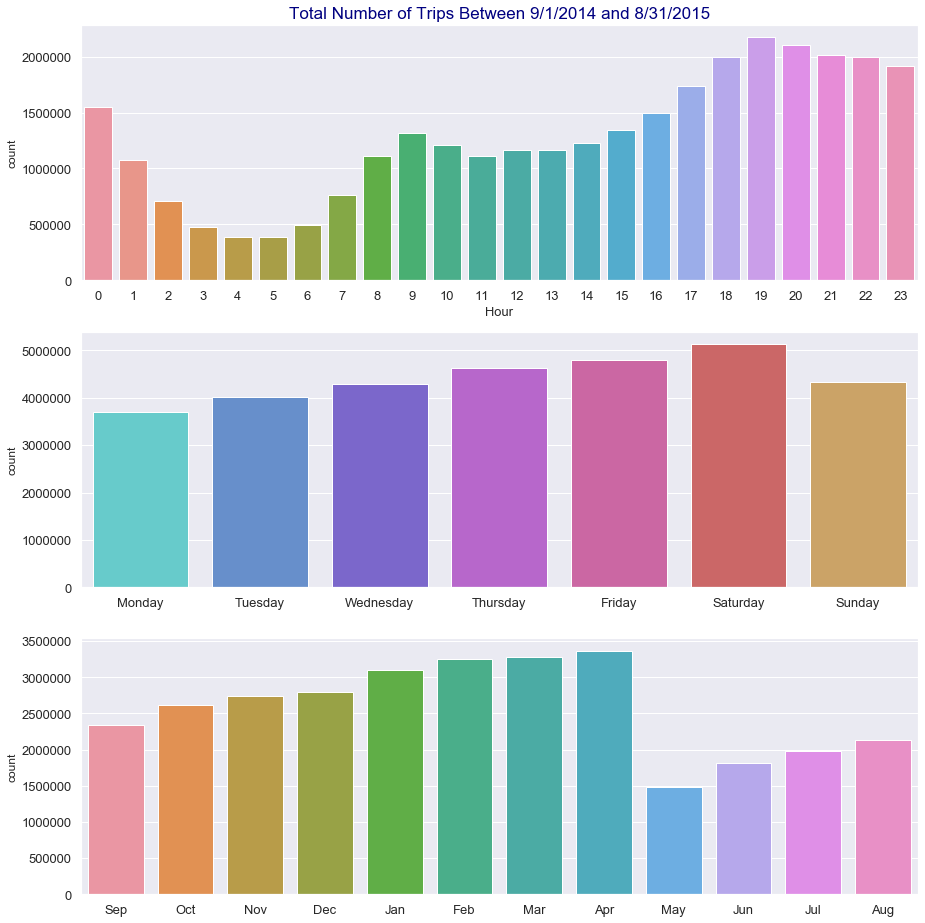

In [65]:
# Create plots comparing demand per different time categories:
fig = plt.figure(figsize = (15,16))

plt.subplot(3,1,1)
ax1 = sns.countplot(df_viz.hour, order = range(24))
plt.tick_params(labelsize=13)
plt.title('Total Number of Trips Between 9/1/2014 and 8/31/2015', fontsize=17, color='navy')
plt.xlabel('Hour', fontsize=13)

plt.subplot(3,1,2)
ax2 = sns.countplot(df_viz.weekday, order = range(7))
ax2.set_xticklabels(weekday_labels)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.subplot(3,1,3) 
ax3 = sns.countplot(df_viz.month)
ax3.set_xticklabels(month_labels)
plt.tick_params(labelsize=13)
plt.xlabel('')

plt.show()

## Estimated Monthly Base Revenue: how much was the NYC market worth in the period?

In [66]:
#Create dataframe with grouped revenue data:
byDateRev = df_viz.groupby('month')['est_revenue'].sum()

In [68]:
#Estimate Uber's gross margin for the entire 1 year period based on 25% share of the base revenue.
sumRev = byDateRev.sum()
# print '${:,.0f}M'.format(sumRev * 1e-6), "Base Revenue   Uber's Base Gross Margin:", '${:,.0f}'.format(sumRev * .25)

In [69]:
#Estimated base gross margin based on information that average UberX fare in Sep 2014 was $27 (but it has dropped):
len(df_viz) * 27 * .25

208735400.25

In [70]:
byDateRev.head()

month
1   41457151.3925
2   47252851.6517
3   52154385.1658
4   54095066.2220
5   61539912.0576
Name: est_revenue, dtype: float64

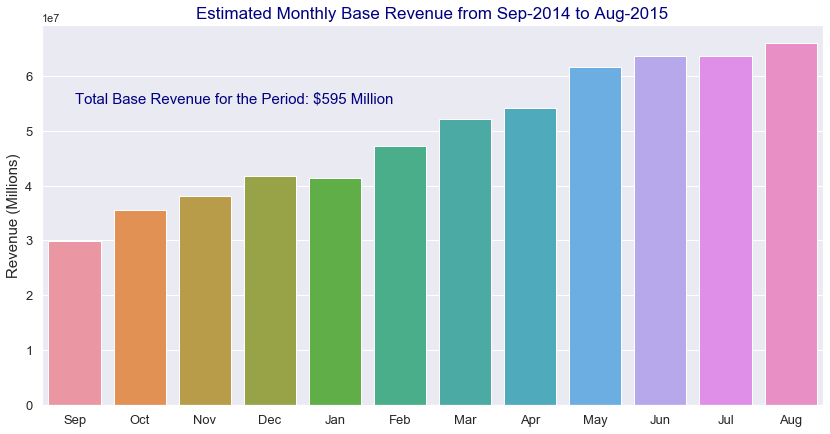

In [71]:
#Create chart showing total base revenue per month.
months_seq = [9,10,11,12,1,2,3,4,5,6,7,8]

plt.figure(figsize = (14, 7))
ax = sns.barplot(byDateRev.index, byDateRev.values, order = months_seq)
ax.set_xticklabels(month_labels)

font = {'color': 'navy', 'size': 15} #text parameters
plt.text(0, 55000000, 'Total Base Revenue for the Period: ${:,.0f} Million'.format(sumRev * 1e-6), 
         fontdict = font) #params: x, y, text, fontdict
plt.xlabel('')
plt.ylabel('Revenue (Millions)', fontsize = 15)
plt.tick_params(labelsize=13)
plt.title('Estimated Monthly Base Revenue from Sep-2014 to Aug-2015', fontsize = 17, color='navy')

plt.show()

In [72]:
#Mean fare from revenue estimate for the period: $19.24 (assumes all trips are Uber X)
df_viz.est_revenue.mean()

19.241869694747738

In [73]:
#Rough estimate of revenue share from Uber Pool from 12/1/2014 to 8/31/2015 (total of 25,634,526 trips):
rev = df_viz[(df_viz.pu_date >= datetime.date(2014, 12, 1)) & (df_viz.pu_date <= datetime.date(2015, 8, 31))]\
.est_revenue.mean() #$19.17 mean revenue

u_pool = rev * 0.75 * 1500000
u_pool #$21,565,512 estimated revenue

D:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


21565512.055648196

In [74]:
u_pool/df_viz[(df_viz.pu_date >= datetime.date(2014, 12, 1)) & (df_viz.pu_date <= datetime.date(2015, 8, 31))]\
.est_revenue.sum() #Uber Pool represented only about 4% of the total revenue for the period between Dec/14 and Aug/15.

D:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


0.04388612451814645

## Month over Month Base Revenue Growth: how fast has Uber grown in the period?

In [77]:
#Create dictionary with calculated month over month revenue percentage growth:
dict_growth = {}
for i in range(len(months_seq)):
    mo = months_seq[i]
    rev = byDateRev[mo]
    if mo == 9:
        growth_pct = 0
    elif mo == 1:
        growth_pct = ((rev/byDateRev[12]) - 1) * 100
    else:
        growth_pct = ((rev/byDateRev[mo - 1]) - 1) * 100
    print (month_labels[i], 'Revenue =', '${:,.0f}'.format(rev), 'Growth % = ', '{:.1f}'.format(growth_pct))
    dict_growth[month_labels[i]] = growth_pct

Sep Revenue = $29,932,282 Growth % =  0.0
Oct Revenue = $35,531,001 Growth % =  18.7
Nov Revenue = $38,170,687 Growth % =  7.4
Dec Revenue = $41,661,569 Growth % =  9.1
Jan Revenue = $41,457,151 Growth % =  -0.5
Feb Revenue = $47,252,852 Growth % =  14.0
Mar Revenue = $52,154,385 Growth % =  10.4
Apr Revenue = $54,095,066 Growth % =  3.7
May Revenue = $61,539,912 Growth % =  13.8
Jun Revenue = $63,667,666 Growth % =  3.5
Jul Revenue = $63,607,348 Growth % =  -0.1
Aug Revenue = $65,961,099 Growth % =  3.7


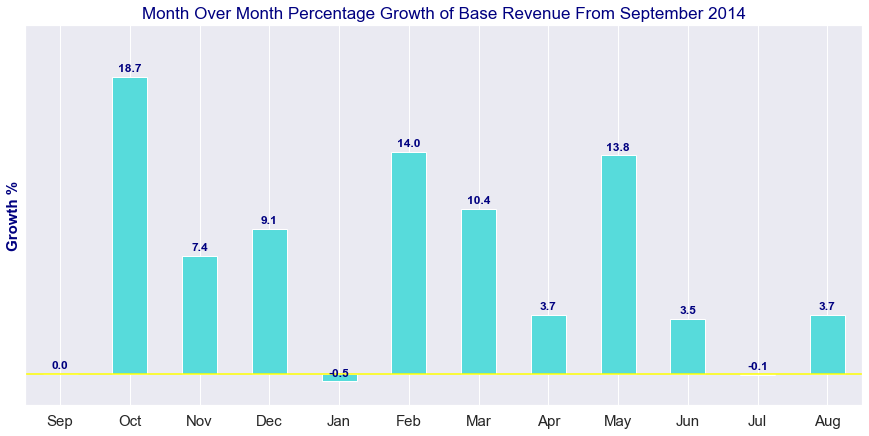

In [78]:
#Annotate Total Cummulative Growth for the Period

df_plt1 = pd.DataFrame(pd.Series(dict_growth), index = month_labels, columns = ['growth_pct'])

labels_list = df_plt1.growth_pct.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt1.plot(kind = 'bar', figsize = (15,7), fontsize = 14, rot = 0, legend=False)#df_plt2[1:] to exclude Sep
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.axhline(0, color='yellow')
plt.title('Month Over Month Percentage Growth of Base Revenue From September 2014', 
          fontsize = 17, color='navy')
plt.ylabel('Growth %', fontsize = 15, weight='bold', color='navy')
plt.ylim(-2, 22)
plt.tick_params(labelsize=15)

plt.show()

Cummulative % Growth Over Period: 83.6883959768883


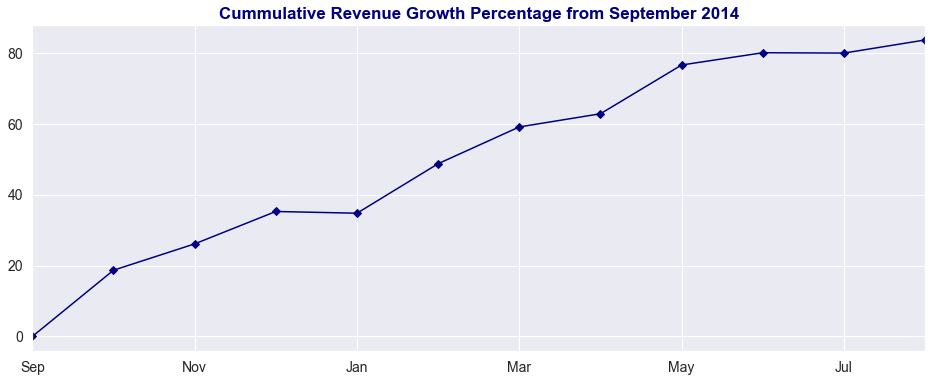

In [81]:
#Plot Cummulative Base Revenue Growth Over the Period
print( 'Cummulative % Growth Over Period:', df_plt1.growth_pct.sum())

df_plt1.cumsum().plot(color = 'navy', marker = 'D', legend = False, figsize=(16, 6))
plt.title('Cummulative Revenue Growth Percentage from September 2014', fontsize=17, weight='bold', color='navy')
plt.tick_params(labelsize=14)
plt.show()

## Which day of the week has the worst (slowest) traffic overall?

In [82]:
#Create dataframe with grouped data.
df_plt2 = df_viz.groupby('weekday')['trip_mph_avg'].median() #used median since distribution is skewed.

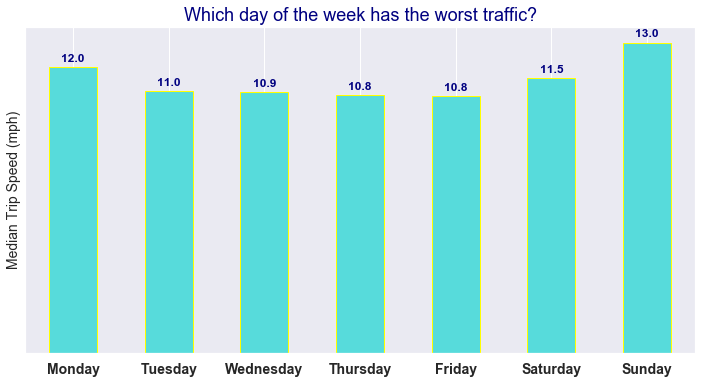

In [83]:
#Create plot. Does Saturday have better traffic flow than Monday?

fig = plt.figure()
labels_list = df_plt2.values.round(1)
kwargs = {'fontsize': 12, 'ha':'center', 'va': 'bottom', 'weight': 'bold', 'color': 'navy'}

ax = df_plt2.plot(kind='bar', rot = 0, figsize = (12, 6), fontsize = 12, edgecolor='yellow', linewidth=1)
ax.set_xticklabels(weekday_labels, weight='bold')
ax.get_yaxis().set_ticks([])
annotate_labels(ax, labels_list, **kwargs)

plt.xlabel('')
plt.ylabel('Median Trip Speed (mph)', fontsize = 14)
plt.tick_params(labelsize=14)
plt.title('Which day of the week has the worst traffic?', fontsize = 18, color='navy')
plt.show()


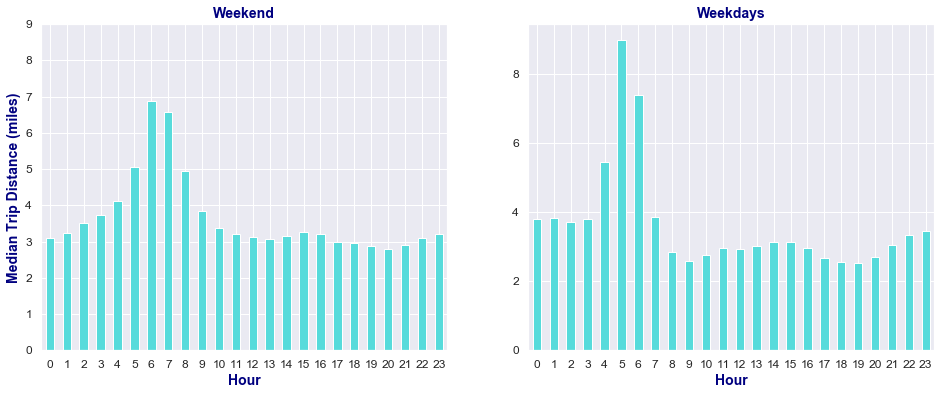

In [84]:
#Why is the median distance traveled around 5 AM much longer than at the other times?
#Could it be picking up riders that would otherwise use public transportation to the outer boroughs? 
#While the subway runs 24/7 in NYC, bus services don't. It's clear though that most customer are within Manhattan.
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
df_viz[(df_viz.weekday >= 5)].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0, fontsize=14)
plt.ylim(0, 9)
plt.tick_params(labelsize=12)
plt.ylabel('Median Trip Distance (miles)', fontsize=14, weight='bold', color='navy')
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekend', fontsize=14, weight='bold', color='navy')

plt.subplot(1,2,2)
df_viz[df_viz.weekday < 5].groupby('hour')['trip_distance'].median().plot(kind='bar', rot = 0)
plt.tick_params(labelsize=12)
plt.xlabel('Hour', fontsize=14, weight='bold', color='navy')
plt.title('Weekdays', fontsize=14, weight='bold', color='navy')

plt.show()

## Visualizing the most popular pick up and drop off location pairs.

In [85]:
#Define data to plot:
df_plt3 = df_viz.pivot_table('id', aggfunc='count', index='origin_taz', columns='destination_taz')

In [86]:
df_plt3.shape

(28, 29)

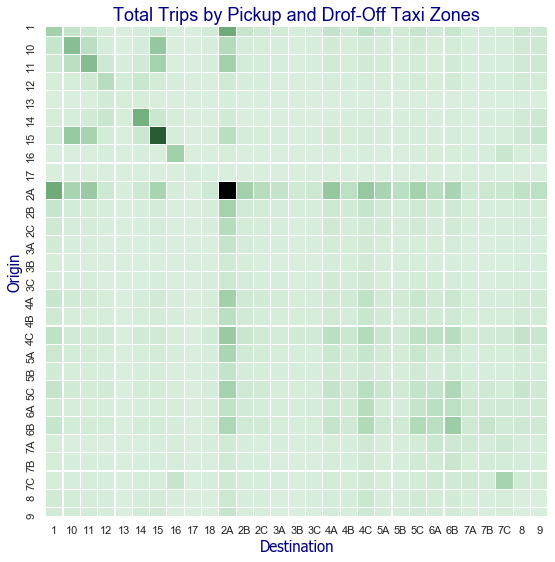

In [87]:
#Visualize the origin versus destination matrix via a heatmap:

fig = plt.figure(figsize=(9,9))

cmap = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.9, as_cmap=True) #'YlOrRd' #ggplot:'viridis'

sns.heatmap(df_plt3, cmap=cmap, linewidths=0.1, cbar=False)

plt.title('Total Trips by Pickup and Drof-Off Taxi Zones', fontsize=18, color='navy')
plt.xlabel('Destination', fontsize=15, fontname='Tahoma', color='navy')
plt.ylabel('Origin', fontsize=15, fontname='Tahoma', color='navy')
plt.tick_params(labelsize=11)
plt.show()

## Plot of the histograms for trip distance and duration

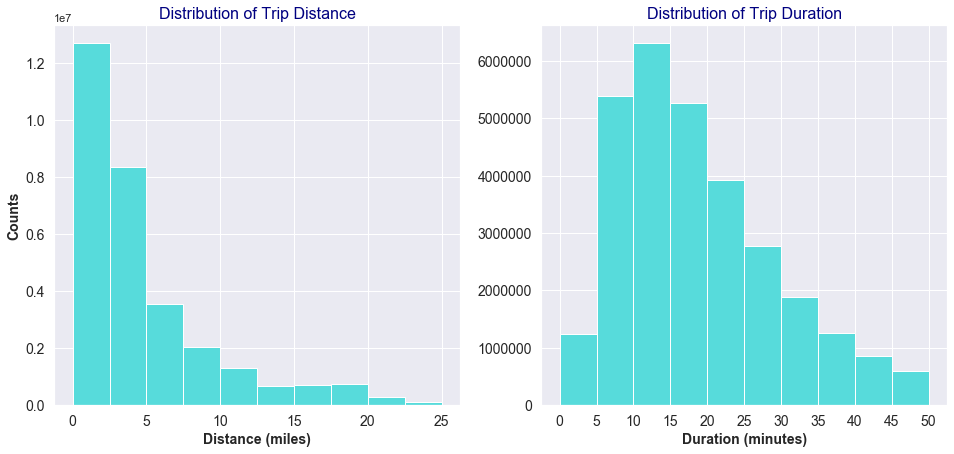

In [88]:
#plot the distribution of trip duration next to the histogram of trip distance for comparison.
fig = plt.figure(figsize=(16, 7))


plt.subplot(1,2,1)
freq, bins_dist = np.histogram(df_viz.trip_distance, bins=10, range=(0, 25))
ax1 = df_viz.trip_distance.dropna().hist(bins=bins_dist)

plt.xlabel('Distance (miles)', fontsize=14, weight='bold')
plt.ylabel('Counts', fontsize=14, weight='bold')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Distance', color='navy', fontsize=16)


plt.subplot(1,2,2)
freq, bins_dur = np.histogram(df_viz.duration_min, bins=10, range=(0, 50))
ax2 = df_viz.duration_min.hist(bins=bins_dur)
ax2.set_xticks(bins_dur) #bins are in 5 minutes intervals.

plt.xlabel('Duration (minutes)', fontsize=14, weight='bold')
plt.ylabel('')
plt.tick_params(labelsize=14)
plt.title('Distribution of Trip Duration', color='navy', fontsize=16)

plt.show()